 ### Part 1. Loading and examining data
 ---

In [1]:
# uncomment if not installed
# !pip3 install optuna
# !pip3 install catboost

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

In [3]:
# loads data
df_train = pd.read_csv('../input/advanced-dls-spring-2021/train.csv')
df_test  = pd.read_csv('../input/advanced-dls-spring-2021/test.csv')
df_out   = pd.read_csv('../input/advanced-dls-spring-2021/submission.csv')

In [4]:
pd.set_option('display.max_columns', 70) 
pd.set_option('display.max_rows', 1000) 
df_train.head(3)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1


In [5]:
def pretty_wrapper(title, func):
    div = (len(title) + 3) * "-"
    print("| " + title + ":\n" + div)
    print(func())
    print(div)
    
# shows quality of data (the presence of empty values and NaN)
pretty_wrapper("Count of NaN in rows by columns:", df_train.isna().sum)
rotten_total_spent   =  df_train.groupby("TotalSpent").get_group(" ").index
rotten_client_period =  df_train.groupby("ClientPeriod").get_group(0).index
rotten_indexes = set(np.append(rotten_total_spent, rotten_client_period))

| Count of NaN in rows by columns::
-----------------------------------
ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64
-----------------------------------


In [6]:
print(rotten_indexes)
df_train.drop(rotten_indexes, axis=0, inplace=True) # those rows are useless...
df_train.TotalSpent = df_train.TotalSpent.astype(float)
# because main fields are filled with rubbish

{4002, 3078, 4326, 4551, 1707, 2543, 3697, 4598, 1048}


In [7]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

target_col = 'Churn'

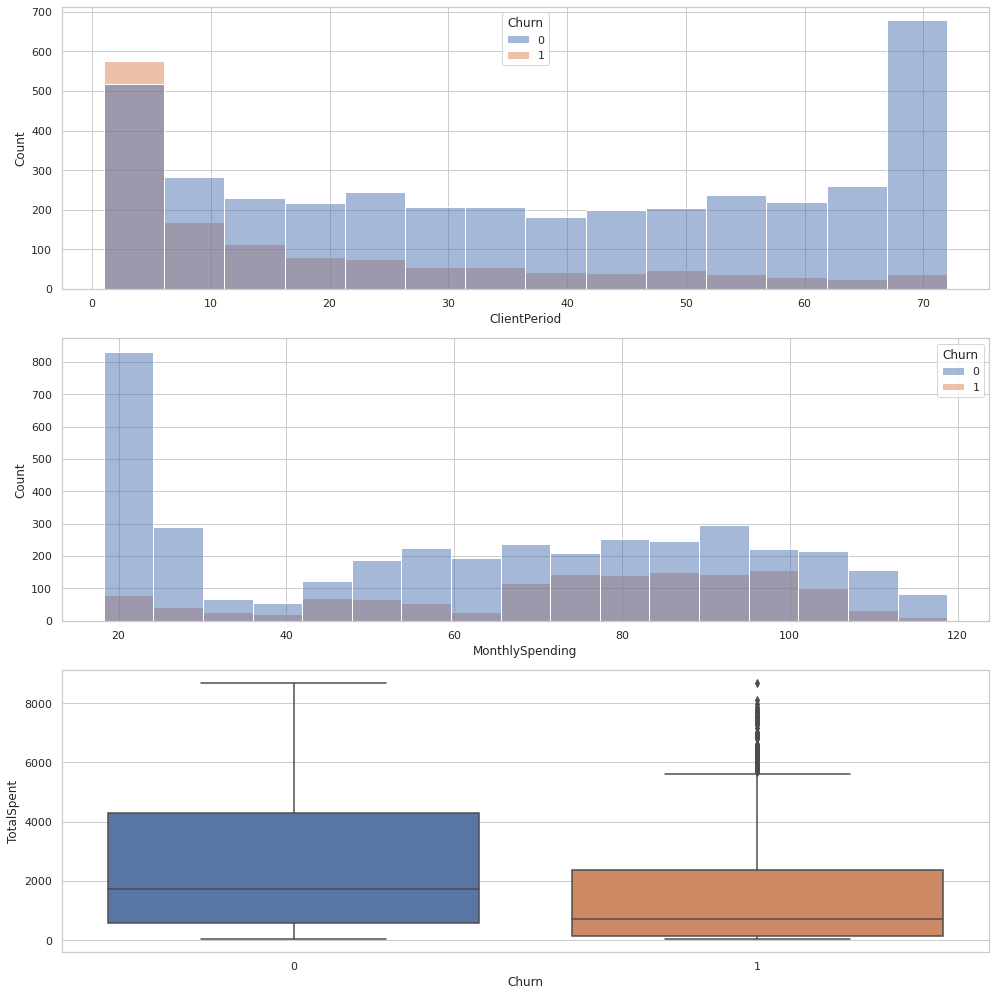

In [8]:
# Examining numeric columns

fig, axs = plt.subplots(3, 1, figsize=(14, 14))

for col, use_ax in zip(['ClientPeriod', 'MonthlySpending'], axs):
    sns.histplot(data=df_train, x=col, hue='Churn', ax=use_ax)
    use_ax.set_xlabel(col)


sns.boxplot(data=df_train, y='TotalSpent', x='Churn', ax=axs[2])
plt.tight_layout()
plt.show()

#### ClientPeriod (important)
- Most of the new clients are leaving
- Customers who have been using the operator's services for more than 40 months are more likely to stay
- (consequence) Customers who have been using the services of the operator for more than 60 months don't turn to other service providers. (This is evidenced by the delta between 67m and 70m)

#### TotalSpent
- **First quartile**: 25% of people spent more than 3700\$
- **Third quartile**: 25% of people are new clients (TotalSpent is small)
- **IQR** shows that <25% people spent more then 2000\$ 

#### MonthlySpending (2'nd important parameter)
- People with tariff [~64$ - ~104$] most likely leave the operator
- The lower payment, the higher chance that person won't leave for another operator

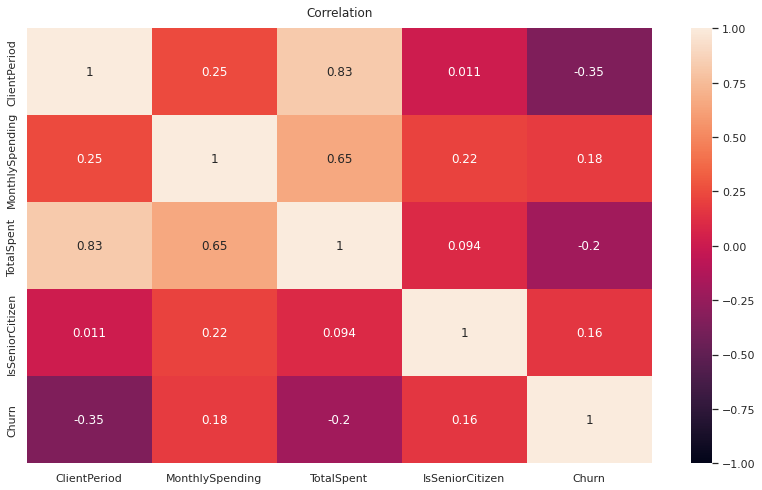

In [9]:
# heatmap for **numeric** parameters
plt.figure(figsize=(14, 8)) 
heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True);
heatmap.set_title('Correlation', fontdict={'fontsize':12}, pad=12);

### Distribution of categorical parameters and target class

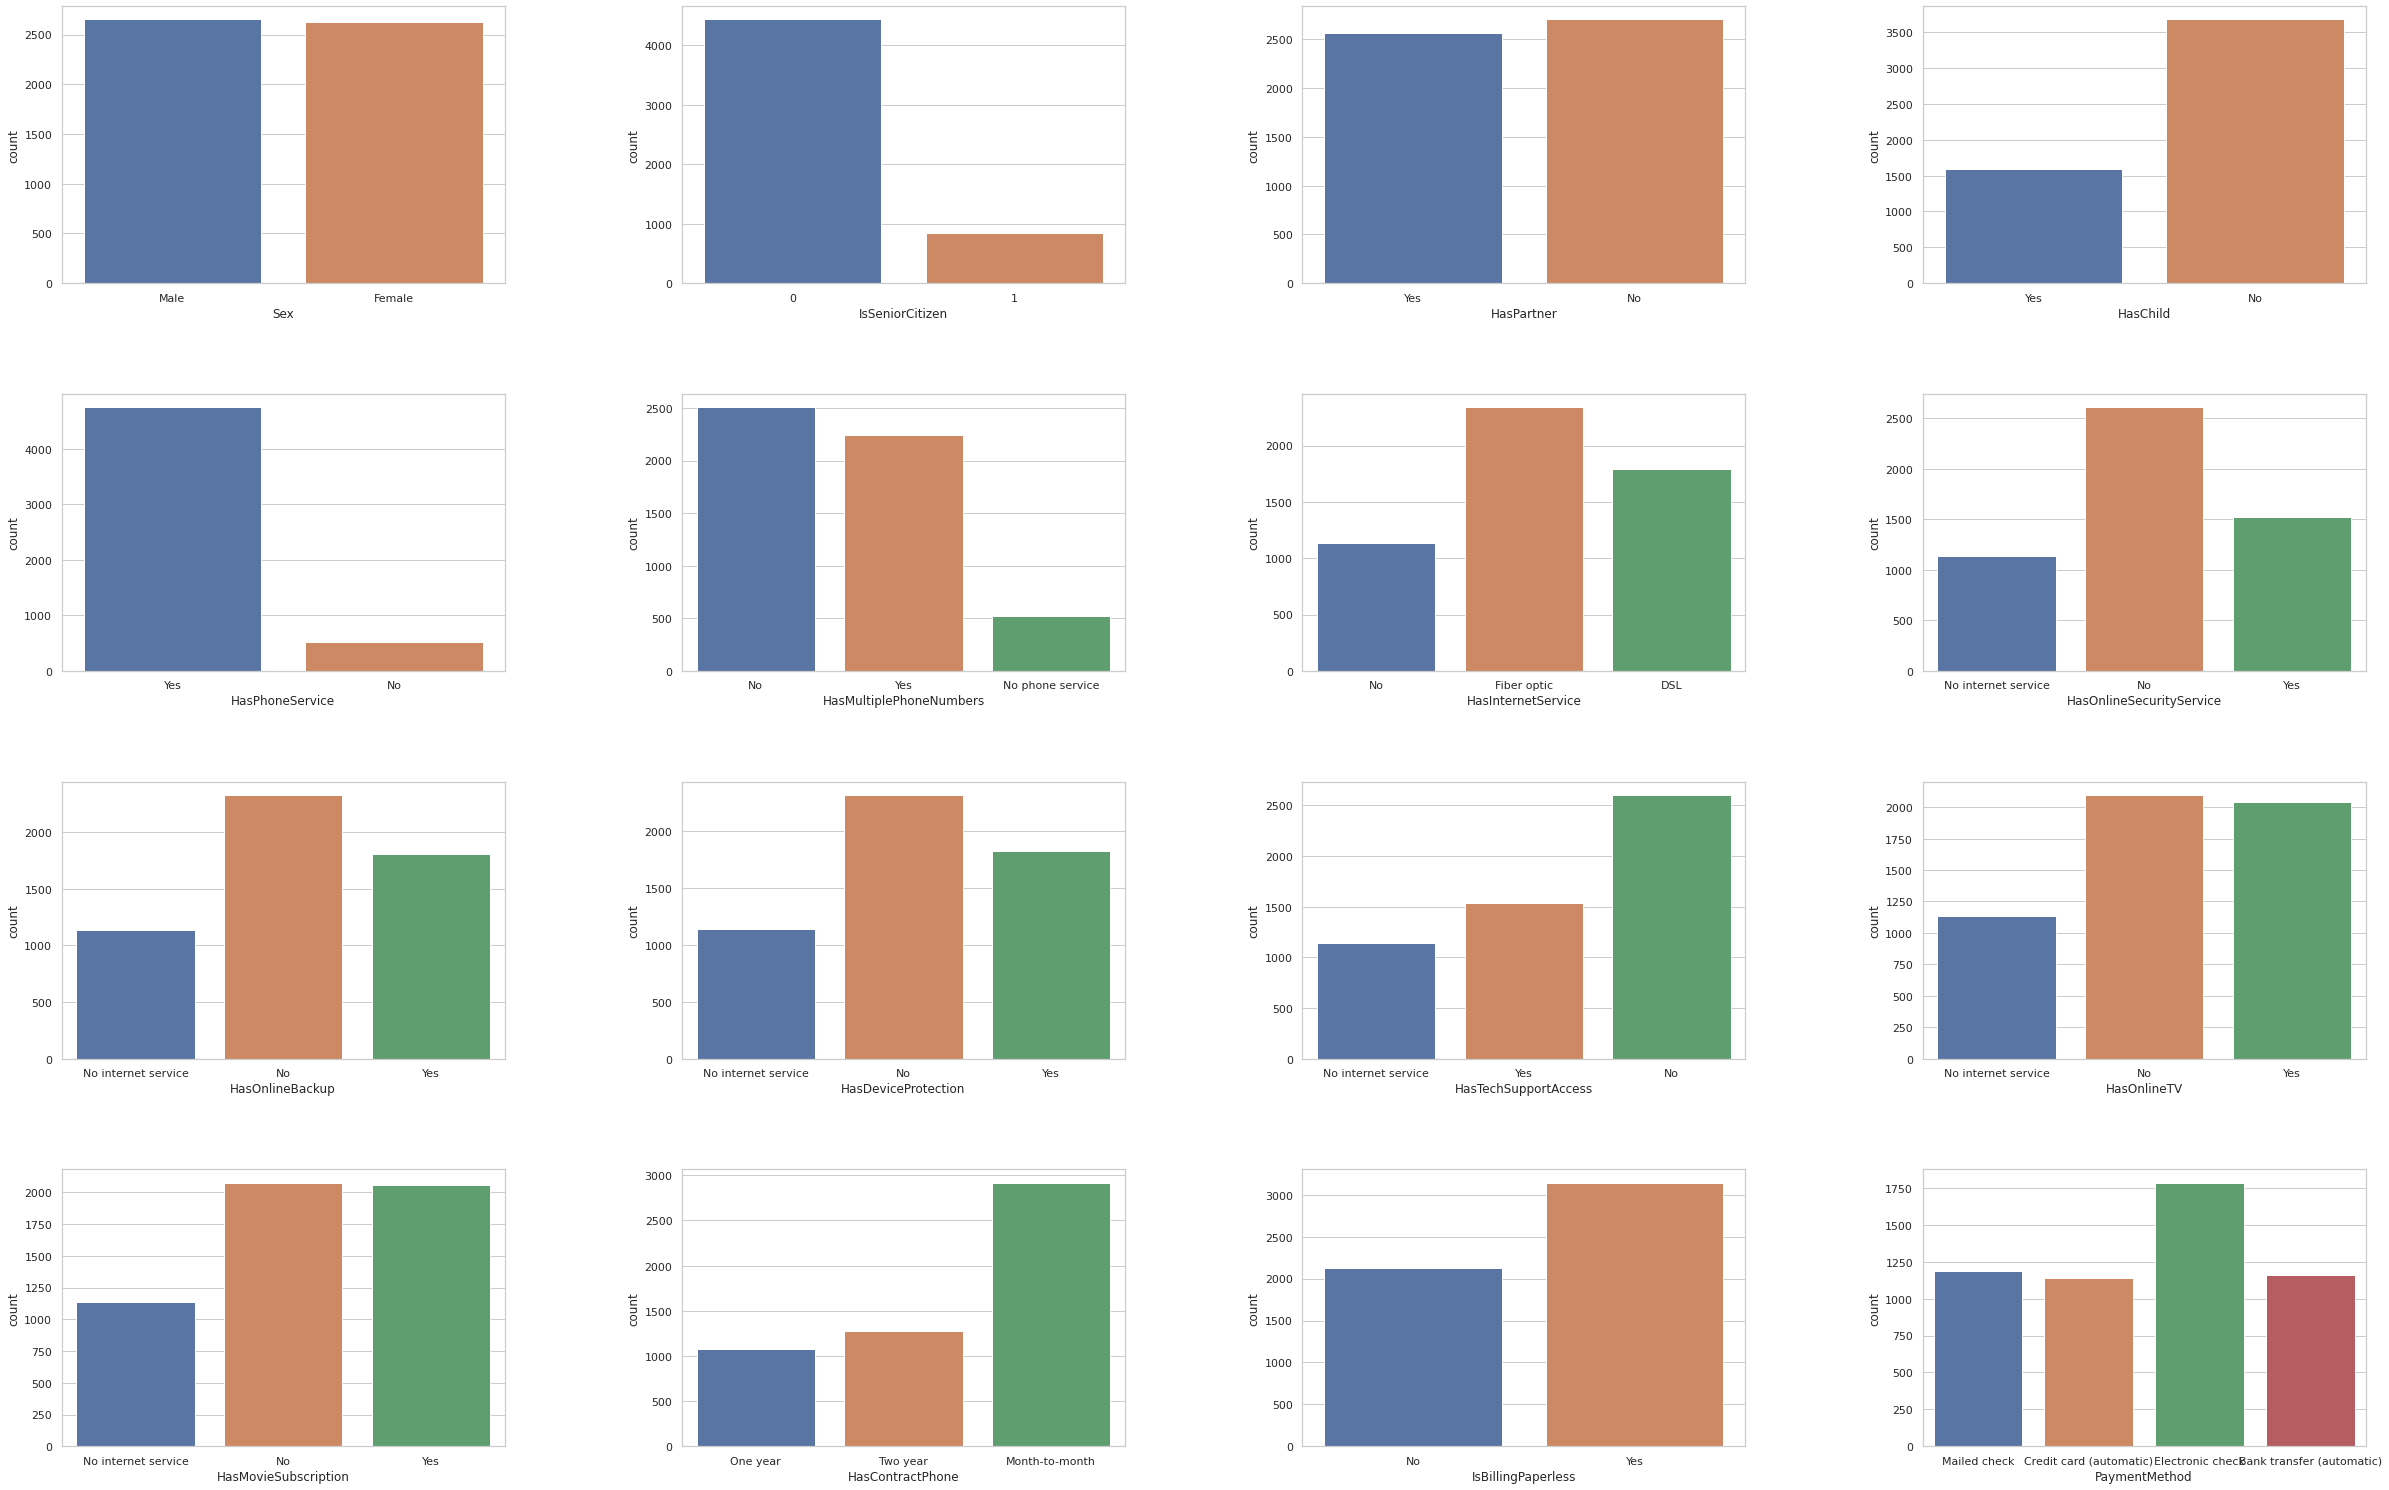

In [10]:
fig, cat_axs = plt.subplots(4, 4, figsize=(40,25))

cat_cols_reshaped = np.array(cat_cols).reshape((4, 4))

for (ax_row, cat_row) in zip(cat_axs, cat_cols_reshaped):
    for (ax, col) in zip(ax_row, cat_row):
        sns.countplot(data=df_train, x=col, ax=ax)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

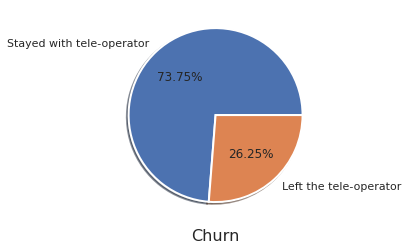

In [11]:
sp = plt.subplot()

plt.pie(df_train[target_col].value_counts(),
    labels=['Stayed with tele-operator', 'Left the tele-operator'],
    shadow=True, startangle=0, labeldistance=1.12,
    wedgeprops={'linewidth' : 2, 'edgecolor' : 'white' }, 
    autopct=lambda pct: f"{pct:.2f}%"
)
sp.set_xlabel("Churn", fontsize=16)

plt.show()
# The number of clients who stayed with the tele-operator is three times more!

 ### Part 2. Creating and training the model
 ---

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
happy_number = 21

x_train, x_test, y_train, y_test = train_test_split(
    df_train[num_cols + cat_cols], df_train[target_col],
    random_state = happy_number,
    test_size    = 0.2,
)

In [13]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler#
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import xgboost as xgb

# one-hot-encode + scale to IQR
r_s   =  RobustScaler()
s_h_e =  OneHotEncoder()

ct = ColumnTransformer([
    ("r_s", r_s, num_cols),
    ("s_h_e", s_h_e, cat_cols),
])

x_train = ct.fit_transform(x_train)
x_test  = ct.fit_transform(x_test)

model = XGBClassifier(
    seed      = happy_number,
    objective = 'binary:logistic',
    n_jobs    = -1,
)

params = {
     'booster':          ['gbtree'],
     'n_estimators':     [8, 10, 12],
     'eta':              [0.07, 0.1, 0.12],
     'max_depth':        [7, 10, 12],
     'min_child_weight': [6, 7, 8, 9],
     'gamma':            [0.03, 0.05, 0.07],
     'colsample_bytree': [0.25, 0.3, 0.35],
     'booster':          ['gblinear'],
     'n_estimators':     [10000],
     'updater':          ['shotgun'],
}

search = GridSearchCV(
    estimator  = model,
    param_grid = params,
    scoring    = 'roc_auc', 
    cv         = 5,
    verbose    = 100,
    n_jobs     = -1,
    refit      = True,
)

# uncomment to run GridSearchCV:
#search.fit(x_train, y_train)
#print(f'Best parameters: {search.best_params_}')

In [14]:
xgb_best_params = {
    'booster':         'gblinear',
    'colsample_bytree': 0.25,
    'eta':              0.12,
    'gamma':            0.03,
    'max_depth':        7,
    'min_child_weight': 6,
    'n_estimators':     10000,
    'updater':          'shotgun',
}

search = XGBClassifier(
    seed      = happy_number,
    objective = 'binary:logistic',
    n_jobs    = -1,
    verbosity = 0,
    **xgb_best_params,
)
search.fit(x_train, y_train)

y_preds = search.predict_proba(x_test)[:,-1]
print(f"roc_auc of best XGBClassifier estimator: {roc_auc_score(y_test, y_preds)}")

roc_auc of best XGBClassifier estimator: 0.8468742114264887


In [15]:
# optima + catboost
import optuna
import catboost as cb
from sklearn.model_selection import train_test_split

# catboost hates OneHotEncoder. Really.
x_train, x_test, y_train, y_test = train_test_split(
    df_train[num_cols + cat_cols], df_train[target_col],
    random_state=happy_number,
    test_size=0.2
)

def cb_objective(trial):

    params = {
        'max_depth':          trial.suggest_int('max_depth', 3, 8),
        'learning_rate':      trial.suggest_float('eta', 0.01, 0.1, log=True),
        'n_estimators':       trial.suggest_int('n_estimators', 280, 520),
        'subsample':          trial.suggest_float('subsample', 0.5, 1.0),
        'l2_leaf_reg':        trial.suggest_float('l2_leaf_reg', 2.5, 4),
        'random_strength':    trial.suggest_float('random_strength', 0.9, 1.4),
        'min_data_in_leaf':   trial.suggest_int('min_data_in_leaf', 1, 5),
        'auto_class_weights': 'Balanced',
        'random_state':       happy_number + 1,
        'grow_policy':        'Lossguide',
        'loss_function':      'Logloss',
        'eval_metric':        'AUC',
    }
    
    model = cb.CatBoostClassifier(**params, cat_features=cat_cols)  
    model.fit(
        x_train, y_train, eval_set = [(x_test, y_test)], verbose = False
    )
    y_pred = model.predict_proba(x_test)[:,1]
    roc_auc = roc_auc_score(y_test, y_pred)

    return roc_auc

In [16]:
# uncomment to brute params
#study = optuna.create_study(direction = 'maximize')
#study.optimize(cb_objective, n_trials=1e6, timeout=60 * 180)

In [17]:
# localhost: happy_number+1 trial 2796
best_params = {'max_depth': 4, 'eta': 0.043090736817732476, 'n_estimators': 467, 'subsample': 0.5198146584723113, 'l2_leaf_reg': 2.898497888520252, 'random_strength': 1.3672819538616403, 'min_data_in_leaf': 1}
# colab: happy_number trial 1318
best_params_2 = {'max_depth': 5, 'eta': 0.09987198744753735, 'n_estimators': 448, 'subsample': 0.5366622308836922, 'l2_leaf_reg': 2.652177404769852, 'random_strength': 1.3313247916735373, 'min_data_in_leaf': 5}

lr_model = cb.CatBoostClassifier(**best_params, cat_features=cat_cols)
lr_model.fit(
    x_train, y_train, eval_set = [(x_test, y_test)], verbose=False
)


In [18]:
rate = roc_auc_score(y_test, lr_model.predict_proba(x_test)[:, -1])
print(f"roc_auc of best CatBoostClassifier estimator: {rate}")

roc_auc of best CatBoostClassifier estimator: 0.854834714992009


`CatBoostClassifier:      0.854834714992009`

---
`XGBClassifier:           0.8468788844547044`

---
=> CatBoostClassifier is better

In [19]:
y_out_preds = lr_model.predict_proba(df_test)[:, -1]

In [20]:
df_out.set_index('Id', inplace=True)

In [21]:
df_out.Churn = y_out_preds
df_out.to_csv('out.csv')